In [1]:
import EnsembleKalmanProcesses: TOMLInterface
import EnsembleKalmanProcesses as EKP
using EnsembleKalmanProcesses.ParameterDistributions
import ClimaCalibrate: observation_map, ExperimentConfig
using ClimaAnalysis
import ClimaCalibrate
using Plots
using JLD2
using Statistics
using YAML
using CairoMakie

┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   DiffEqBaseChainRulesCoreExt [b00db79b-61e3-50fb-b26f-2d35b2d9e4ed]
│   StaticArrayInterface [0d7ed370-da01-4f52-bd93-41d350b8b718]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   LinearOperatorsCUDAExt [54ba8605-469e-5680-a54a-585c2e64e6c1]
│   Polyester [f517fe37-dbe3-4b94-8317-1923a5111588]
│   ClimaCore [d414da3d-4745-48bb-8d80-42e94e092884]
│   CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
│   NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c]
│   MathTeXEngine [0a4f8689-d25c-4efe-a92b-7142dfc1aa53]
│   ClimaCoreMakie [908f55d8-4145-4867-9c14-5dad1a479e4d]
│   FiniteDiffSparseArraysExt [699899dd-2948-59d9-a4f6-ce210f3f1f61]
│   RRTMGP [a01a1ee8-cea4-48fc-987c-fc7878d79da1]
│   LayoutPointers [10f19ff3-798f-405d-979b-55457f8fc047]
│   CUDAExt [11b7e2e0-d079-575b-885e-0ab22ef3252c]
│   ClimaUtilitiesClimaCoreInterpolationsExt [0a0a4c67-443a-5cd9-a529-60c88b1c335b]
│   ClimaUtiliti

LoadError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [2]:
using Revise
includet("helper_funcs.jl")
includet("observation_map.jl")

┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   DiffEqBaseChainRulesCoreExt [b00db79b-61e3-50fb-b26f-2d35b2d9e4ed]
│   StaticArrayInterface [0d7ed370-da01-4f52-bd93-41d350b8b718]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   LinearOperatorsCUDAExt [54ba8605-469e-5680-a54a-585c2e64e6c1]
│   Polyester [f517fe37-dbe3-4b94-8317-1923a5111588]
│   ClimaCore [d414da3d-4745-48bb-8d80-42e94e092884]
│   CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
│   NLSolversBase [d41bc354-129a-5804-8e4c-c37616107c6c]
│   MathTeXEngine [0a4f8689-d25c-4efe-a92b-7142dfc1aa53]
│   ClimaCoreMakie [908f55d8-4145-4867-9c14-5dad1a479e4d]
│   FiniteDiffSparseArraysExt [699899dd-2948-59d9-a4f6-ce210f3f1f61]
│   RRTMGP [a01a1ee8-cea4-48fc-987c-fc7878d79da1]
│   LayoutPointers [10f19ff3-798f-405d-979b-55457f8fc047]
│   CUDAExt [11b7e2e0-d079-575b-885e-0ab22ef3252c]
│   ClimaUtilitiesClimaCoreInterpolationsExt [0a0a4c67-443a-5cd9-a529-60c88b1c335b]
│   ClimaUtiliti

In [3]:
output_dir = "/scratch/julian/calibrations/exp_7_fix_rsut"
config_i = 1
ylims = (0, 4000)
iteration = nothing
var_names = ("thetaa", "hus", "clw", "arup", "entr", "detr", "waup", 
                "tke", "turbentr", "ta", "rlut", "rsut", "clwvi", "clivi")

reduction = "inst"

config_dict =
    YAML.load_file(joinpath(output_dir, "configs", "experiment_config.yml"))
const z_max = config_dict["z_max"]
const cal_var_names = config_dict["y_var_names"]
const const_noise_by_var = config_dict["const_noise_by_var"]
const n_vert_levels = config_dict["dims_per_var"]
model_config_dict =
    YAML.load_file(joinpath(output_dir, "configs", "model_config.yml"));

In [4]:
ref_paths, months, sites = get_era5_calibration_library()
atmos_config = CA.AtmosConfig(model_config_dict)

# get/store LES obs and norm factors 
zc_model = get_z_grid(atmos_config, z_max = z_max)

# if isnothing(iterations)
#     iterations = get_iters_with_config(config_i, config_dict)
# end

xlims_dict = Dict("arup" => (-0.1, 0.4), "clw" => "auto")

┌ Warning: Failed to convert `config_dict["truncation"] = 40000` to default type String, keeping original value
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/yaml_helper.jl:81
[ Info: Running on CPUSingleThreaded.
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode.
┌ Warning: `job_id` is empty and likely not passed to AtmosConfig.
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/types.jl:643
┌ Info: Making AtmosConfig with config files: 
└    /home/jschmitt/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
┌ Info: Topography
└   topography = "NoWarp"
┌ Warning: perturb_initstate flag is ignored for single column configuration
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/type_getters.jl:200
┌ Warning: Bubble correction not compatible with single column configuration. It will be switched off.
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/type_getters.jl:211
[ Info: Truncating grid to 162 elements below 40000 meters.
┌ Info: Resolution stats

Dict{String, Any} with 2 entries:
  "clw"  => "auto"
  "arup" => (-0.1, 0.4)

In [5]:
function compute_plot_limits(data; margin_ratio = 0.5, fixed_margin = 1.0)

    min_val = minimum(data)
    max_val = maximum(data)

    data_range = max_val - min_val
    margin = data_range == 0 ? fixed_margin : margin_ratio * data_range
    limits = (min_val - margin, max_val + margin)

    return limits
end


compute_plot_limits (generic function with 1 method)

In [6]:
integrated_vars = ["rsut", "rlut", "clwvi", "clivi", "pr"]
t = [[ensemble_data(
    process_profile_variable,
    i, 
    1, 
    config_dict;
    var_name = var_name,
    reduction = reduction,
    output_dir = output_dir,
    z_max = z_max,
    n_vert_levels = n_vert_levels, 
) for i in 1:10] for var_name in integrated_vars];

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
┌ Info: Error during observation map for ensemble member 4
└   err = Simulation failed.
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Com

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT

G_ensemble shape: (1, 50)


[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
[ Info: Computing net shortwave radiation, NOT rsut!
┌ Info: Error during observation map for ensemble member 4
└   err = Simulation failed.
┌ Info: Error during observation map for ensemble member 24
└   err = Simulation failed.


G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)


┌ Info: Error during observation map for ensemble member 4
└   err = Simulation failed.
┌ Info: Error during observation map for ensemble member 24
└   err = Simulation failed.


G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)


┌ Info: Error during observation map for ensemble member 4
└   err = Simulation failed.
┌ Info: Error during observation map for ensemble member 24
└   err = Simulation failed.


G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)


┌ Info: Error during observation map for ensemble member 4
└   err = Simulation failed.
┌ Info: Error during observation map for ensemble member 24
└   err = Simulation failed.


G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)
G_ensemble shape: (1, 50)


In [7]:
eki_filepath = joinpath(
    ClimaCalibrate.path_to_iteration(output_dir, 0),
    "eki_file.jld2",
)
eki = JLD2.load_object(eki_filepath);

In [8]:
dims_per_var = 1
y_truth = get_obs(
    ref_paths[1],
    months[1],
    sites[1],
    integrated_vars;
    normalize = false, 
    z_scm = zc_model,
    log_vars = [""],
)

1
1
1
1
1


5-element Vector{Float32}:
 362.5086
 283.8414
   0.039566804
   0.0015823364
   1.2363494f-5

In [10]:
# hist()
label_dict = Dict(
    "rsut" => "TOA Shortwave (W/m^2)",
    "rlut" => "TOA Longwave (W/m^2)",
    "clwvi" => "Cloud Water Path (kg/m^2)",
    "clivi" => "Cloud Ice Path (kg/m^2)",
    "pr" => "Precipitation (mm/s)",
)

function filtnan(x, i=1)
    x[:, .!isnan.(x[i, :])][:]
end
fig = Figure(size = (1000, 1300))
for (ind, name) in enumerate(integrated_vars)
    ax = Axis(fig[ind, 1], xlabel = "Iteration", ylabel = label_dict[name])
    for i in 1:10
        data = filtnan.(t[ind])[i]
        if name in ["pr"] # flip because era5 is directionally challenged 
            data = -data
        end
        if iszero(data) # violin plot is misleading when all entries are zero
            Makie.scatter!(ax, repeat([i-1], length(data)), data, color = :black)
        elseif i == 1 # add legend
            Makie.violin!(ax, repeat([i-1], length(data)) , data, show_median = true, color = (:blue, 0.5), label = "Ensemble")
        else
            Makie.violin!(ax, repeat([i-1], length(data)) , data, show_median = true, color = (:blue, 0.5))
        end
    end
    Makie.hlines!(ax, [y_truth[ind]], color = :red, label = "ERA5 Observation")
    if ind == 1
        axislegend(ax, position = :rb)
    end
end
# ax = Axis(fig[1, 1], xlabel = "Iteration", ylabel = "Shortwave TOA (W/m^2)")
# for i in 1:10
#     Makie.violin!(ax, repeat([i-1], length(filtnan.(t)[i])) , filtnan.(t)[i], show_median = true)
# end
save(joinpath(output_dir, "plots", "integrated_simulation_violin.png"), fig, px_per_unit = 3)

CairoMakie.Screen{IMAGE}


In [9]:
output_dir

"/scratch/julian/calibrations/exp_7_fix_rsut"

In [14]:
# let's plot column variables
col_vars = ["ta", "hus", "clw"]

ensemble_data(
    process_profile_variable,
    1, 
    1, 
    config_dict;
    var_name = "ta",
    reduction = reduction,
    output_dir = output_dir,
    z_max = 4000,
    n_vert_levels = 62, 
)

G_ensemble shape: (62, 50)
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]


┌ Info: Error during observation map for ensemble member 4
└   err = Simulation failed.


Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.025920

┌ Info: Error during observation map for ensemble member 24
└   err = Simulation failed.



inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]
Processing ta
inst216000.0259200.04000nothingAny[]


┌ Info: Error during observation map for ensemble member 47
└   err = Simulation failed.


62×50 Matrix{Float64}:
 298.437  298.398  298.299  NaN  298.354  …  NaN  298.238  298.278  298.333
 298.159  298.118  298.007  NaN  298.071     NaN  297.936  297.98   298.045
 297.875  297.832  297.714  NaN  297.781     NaN  297.642  297.688  297.752
 297.584  297.539  297.416  NaN  297.483     NaN  297.343  297.39   297.451
 297.288  297.244  297.114  NaN  297.178     NaN  297.041  297.086  297.145
 296.986  296.953  296.819  NaN  296.867  …  NaN  296.742  296.777  296.836
 296.674  296.653  296.524  NaN  296.547     NaN  296.44   296.459  296.524
 296.351  296.338  296.214  NaN  296.218     NaN  296.123  296.132  296.204
 296.019  296.013  295.886  NaN  295.881     NaN  295.794  295.796  295.874
 295.678  295.677  295.549  NaN  295.535     NaN  295.456  295.453  295.533
 295.328  295.331  295.202  NaN  295.18   …  NaN  295.109  295.098  295.182
 294.969  294.971  294.845  NaN  294.818     NaN  294.751  294.735  294.82
 294.599  294.603  294.478  NaN  294.454     NaN  294.383  294.377

In [ ]:
output_dir = "/home/jschmitt/ClimaAtmos.jl/calibration/experiments/reanalysis_forcing/toa_cal/output/prognostic_edmfx_era5driven_column/output_003"
config_i = 1
ylims = (0, 4000)
iteration = nothing
var_names = ("thetaa", "hus", "clw", "arup", "entr", "detr", "waup", 
                "tke", "turbentr", "ta", "rlut", "rsut", "clwvi", "clivi")

reduction = "inst"

config_dict =
    YAML.load_file(joinpath(output_dir, "configs", "experiment_config.yml"))
const z_max = config_dict["z_max"]
const cal_var_names = config_dict["y_var_names"]
const const_noise_by_var = config_dict["const_noise_by_var"]
const n_vert_levels = config_dict["dims_per_var"]
model_config_dict =
    YAML.load_file(joinpath(output_dir, "configs", "model_config.yml"));

In [15]:
# member_path = path_to_ensemble_member(config_dict["output_dir"], 3, 1)
# simdir = SimDir(joinpath(member_path, "config_1", "output_0000"))

process_profile_variable(
    SimDir("output/prognostic_edmfx_era5driven_column/output_active"),
    "rsut";
    reduction = "inst",
    t_start = 1*86400,
    t_end = 1.5*86400,
    z_max = 4000,
    norm_factors_dict= nothing,
    log_vars = [],

)




[ Info: Computing net shortwave radiation, NOT rsut!


293.9226f0

In [10]:

process_rsut(SimDir("output/prognostic_edmfx_era5driven_column/output_0003"), "inst", .4*86400, .5*86400)

301.35687f0

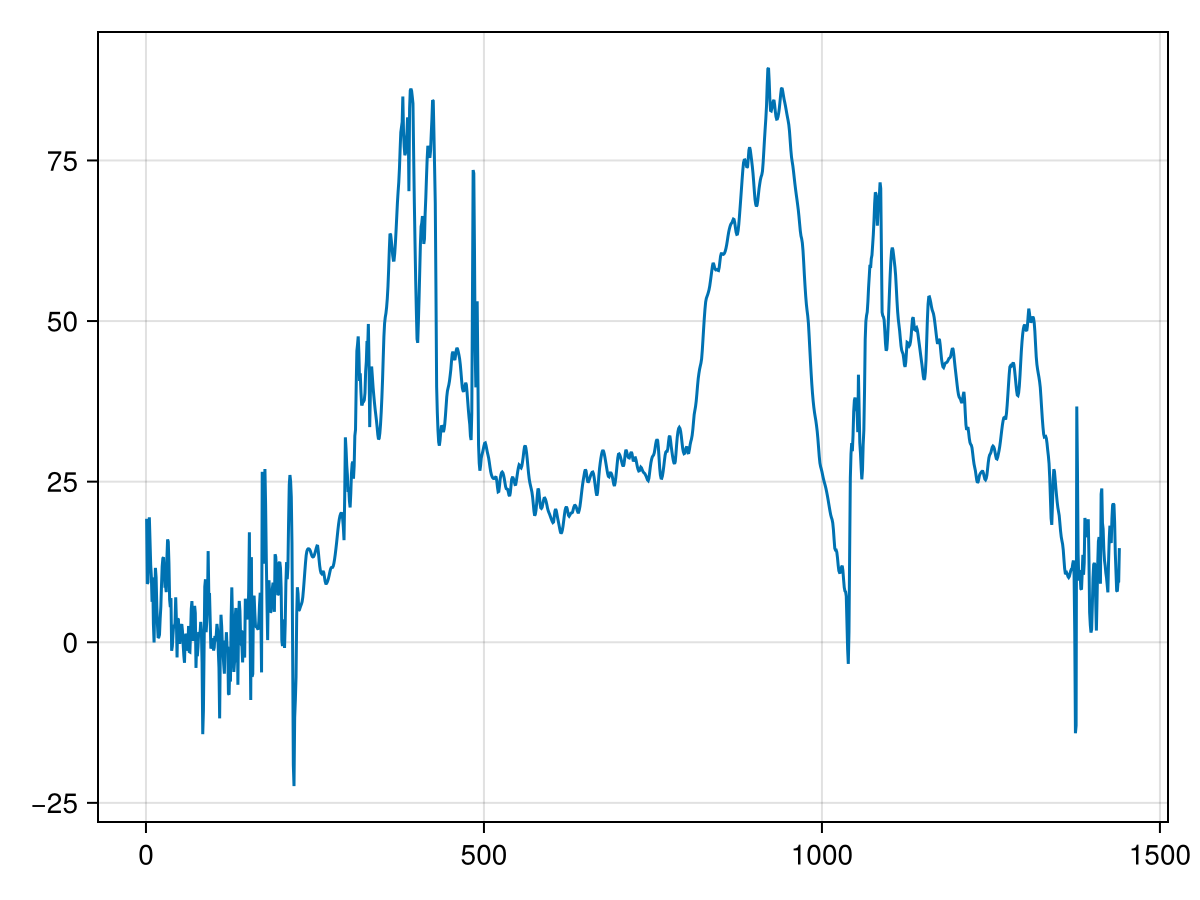

In [27]:
# load cloud radiative effect
using NCDatasets

era5 = NCDataset("/scratch/julian/ERA5/integrated_1.nc")


lon = era5["longitude"][:]
lat = era5["latitude"][:]

# site 23 indexes
lon_idx = argmin(abs.(lon .-211))
lat_idx = argmin(abs.(lat .- 17))

swf = era5["mtnswrf"][:, lat_idx, lon_idx]
swfcs = era5["mtnswrfcs"][:, lat_idx, lon_idx]

lines(swfcs - swf)



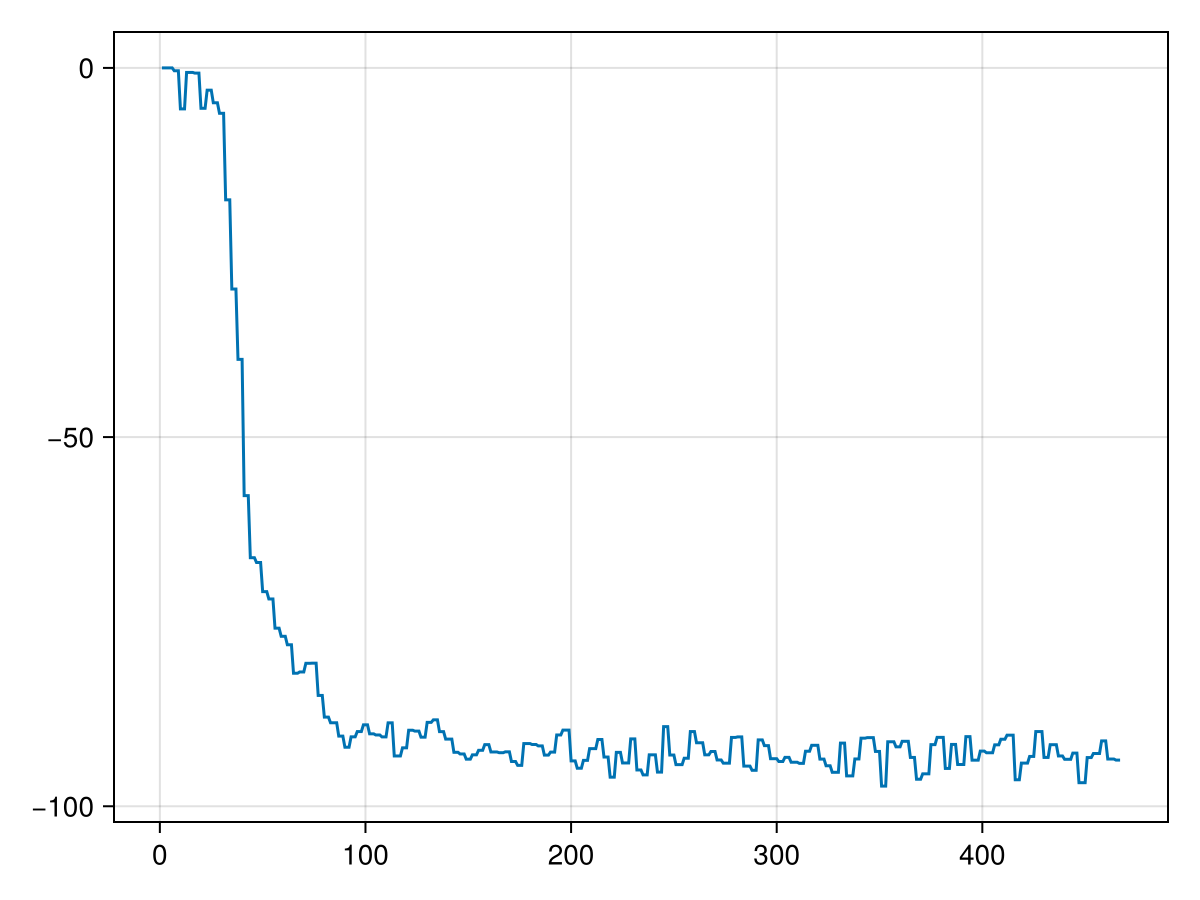

In [33]:
# read from 
simdir = SimDir("/scratch/julian/calibrations/exp_6_month_cov/iteration_010/member_001/config_1/output_0000")

rsutcs = get(simdir, "rsutcs")
rsut = get(simdir, "rsut")

lines(rsutcs.data[:, 1, 1] - rsut.data[:, 1, 1])

In [24]:
using NCDatasets
geo = NCDataset("/scratch/julian/ERA5/geolocation.nc")
site_id = findfirst(geo["site"][:] .== 17)

site_lat = geo["lat"][site_id]
site_lon = geo["lon"][site_id]
println(site_lat, "  ", site_lon)

35.0  235.0


In [ ]:
16, 210
36, 236


CommonDataModel.Attributes{NCDataset{Nothing, Missing}} with 1 entry:
  "__xarray_dataarray_name__" => "lon"

In [4]:
using ClimaAnalysis


┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   GridLayoutBase [3955a311-db13-416c-9275-1d80ed98e5e9]
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   SciMLOperatorsStaticArraysCoreExt [a2df0a61-553a-563b-aed7-0ce21874eb58]
│   DiffEqBaseChainRulesCoreExt [b00db79b-61e3-50fb-b26f-2d35b2d9e4ed]
│   StaticArrayInterface [0d7ed370-da01-4f52-bd93-41d350b8b718]
│   RecursiveArrayToolsFastBroadcastExt [42296aa8-c874-5f57-b5c1-8d6f5ebd5400]
│   SciMLBase [0bca4576-84f4-4d90-8ffe-ffa030f20462]
│   GPUArrays [0c68f7d7-f131-5f86-a1c3-88cf8149b2d7]
│   DiffEqBaseCUDAExt [78064ecb-8a7e-51fd-a998-f0197ddca326]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   CreateParametersExt [de10cf08-5a56-53da-a061-ea54c6b27d66]
│   RecursiveArrayToolsStructArraysExt [07510ace-05c5-59ac-8535-cc0df8d4a157]
│   RecursiveArrayToolsSparseArraysExt [73e54eaf-3344-511d-b088-1ac5413eca63]
│   StrideArraysCore [7792a7ef-975c-4747-a70f-980b88e8d1da]
│  

In [7]:
function process_rsut(simdir, reduction, t_start, t_end)
    # get rsdt (TOA incoming solar radiation) and rsut (TOA outgoing solar radiation)
    # net TOA = rsdt - rsut
    @info "Computing net shortwave radiation, NOT rsut!"
    rsdt = get(simdir; short_name = "rsdt", reduction = reduction)
    rsut = get(simdir; short_name = "rsut", reduction = reduction)

    sim_t_end = rsut.dims["time"][end]
    if sim_t_end < 0.95 * t_end
        throw(ErrorException("Simulation failed."))
    end

    rsdt_ave = average_time(window(rsdt, "time", left = t_start, right = sim_t_end))
    rsut_ave = average_time(window(rsut, "time", left = t_start, right = sim_t_end))

    rsdt_data = slice(rsdt_ave, x = 1, y = 1).data
    rsut_data = slice(rsut_ave, x = 1, y = 1).data

    # net shortwave radiation is incoming minus outgoing shortwave radiation
    net_shortwave_radiation = rsdt_data .- rsut_data

    return net_shortwave_radiation
end

process_rsut (generic function with 1 method)

In [10]:
process_rsut(SimDir("output/prognostic_edmfx_tv_era5driven_column/output_active/"), "inst", 86400, 2*86400)

[ Info: Computing net shortwave radiation, NOT rsut!


220.45438f0

In [2]:
function compute_cre(simdir, reduction, t_start, t_end)
    rsutcs = get(simdir; short_name = "rsutcs", reduction = reduction)
    rsut = get(simdir; short_name = "rsut", reduction = reduction)

    sim_t_end = rsut.dims["time"][end]
    if sim_t_end < 0.99 * t_end # higher tolerance since this is diurnal cycle
        throw(ErrorException("Simulation failed."))
    end
    # average the period of interest. 
    rsutcs_ave = average_time(window(rsutcs, "time", left = t_start, right = sim_t_end))
    rsut_ave = average_time(window(rsut, "time", left = t_start, right = sim_t_end))

    rsutcs_data = slice(rsutcs_ave, x = 1, y = 1).data
    rsut_data = slice(rsut_ave, x = 1, y = 1).data

    # compute CRE 
    cre = rsutcs_data .- rsut_data
    return cre 
end

compute_cre(SimDir("output/prognostic_edmfx_tv_era5driven_column/output_active/"), "inst", 0, 2*86400)
    

-3.6384583f0

In [16]:
using Pkg; Pkg.add("DateTime")

LoadError: The following package names could not be resolved:
 * DateTime (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mD[22m[0m[1ma[22m[0m[1mt[22m[0m[1me[22m[0m[1mT[22m[0m[1mi[22m[0m[1mm[22m[0m[1me[22ms64 UTC[0m[1mD[22m[0m[1ma[22m[0m[1mt[22m[0m[1me[22m[0m[1mT[22m[0m[1mi[22m[0m[1mm[22m[0m[1me[22ms LaxZone[0m[1md[22mD[0m[1ma[22m[0m[1mt[22m[0m[1me[22m[0m[1mT[22m[0m[1mi[22m[0m[1mm[22m[0m[1me[22ms

93 125


-43.54347


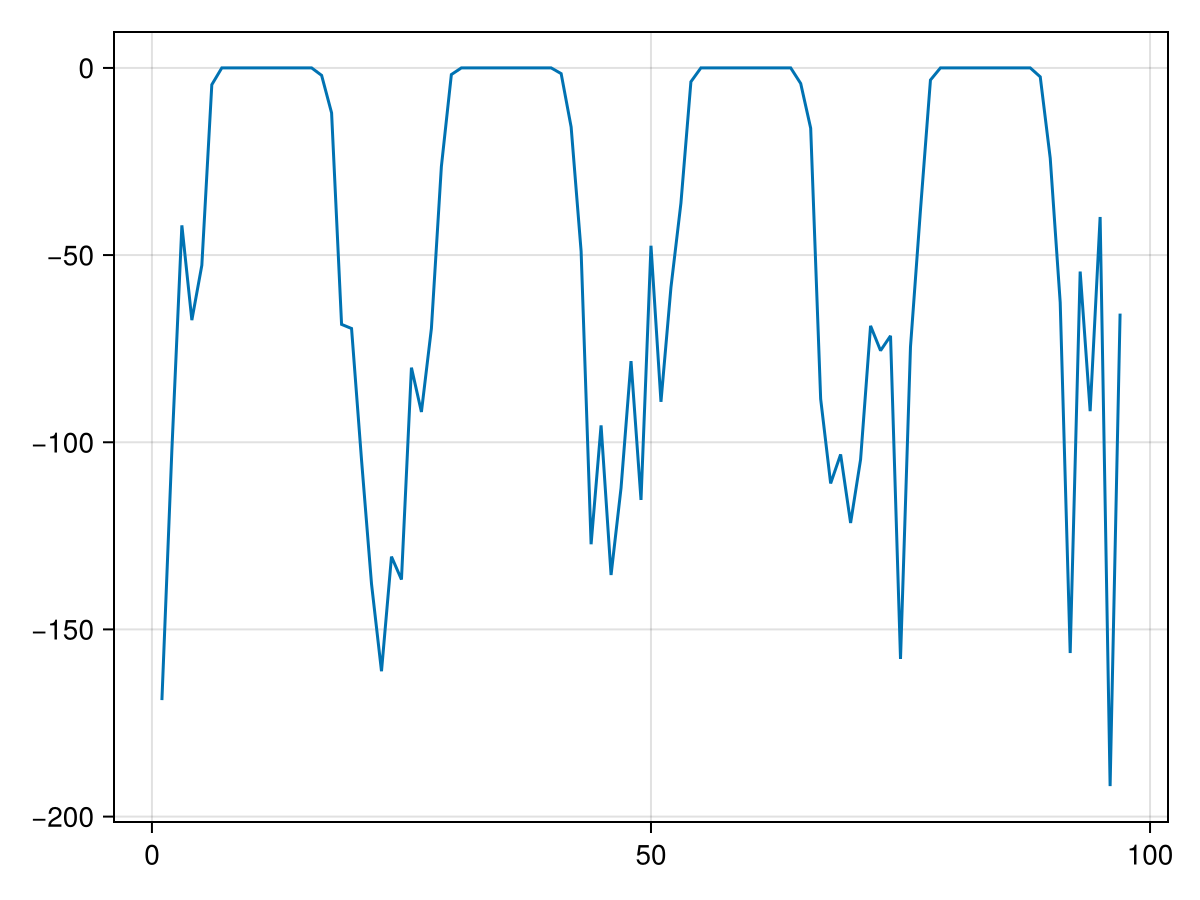

In [ ]:
# observational dataset
using NCDatasets, DimensionalData, Dates, CairoMakie, Statistics
cloud_diagnostics = "/scratch/julian/ERA5/data_download/july2007_hourly_inst.nc"
radiation_diagnostics = "/scratch/julian/ERA5/data_download/july2007_hourly_accum.nc"

lat = 17.
lon = -149.

function compute_era5_cre(fpath, lat, lon, t_start, t_end)
    rad = NCDataset(fpath)

    # Extract the variables
    tsr = rad[:tsr]
    tsrc = t[:tsrc]
    ds_time = t[:valid_time]

    # create the time mask
    t_start = Dates.DateTime("2007-07-01T00:00:00")
    t_end = Dates.DateTime("2007-07-05T00:00:00")
    time_mask = (ds_time .>= t_start) .& (ds_time .<= t_end)

    # get latitude indices
    lat_idx = argmin(abs.(t[:latitude][:] .- lat))
    lon_idx = argmin(abs.(t[:longitude][:] .- lon))

    println(lat_idx, " ", lon_idx)

    # select the data
    tsr_sel = tsr[lon_idx, lat_idx, findall(time_mask)] ./ 3600
    tsrc_sel = tsrc[lon_idx, lat_idx, findall(time_mask)] ./ 3600
    avg_cre = mean(tsr_sel .- tsrc_sel)
    println(avg_cre)

end

t = NCDataset(radiation_diagnostics)

# Extract the variables
tsr = t[:tsr]
tsrc = t[:tsrc]
ds_time = t[:valid_time]

# create the time mask
t_start = Dates.DateTime("2007-07-01T00:00:00")
t_end = Dates.DateTime("2007-07-05T00:00:00")
time_mask = (ds_time .>= t_start) .& (ds_time .<= t_end)

# get latitude indices
lat_idx = argmin(abs.(t[:latitude][:] .- lat))
lon_idx = argmin(abs.(t[:longitude][:] .- lon))

println(lat_idx, " ", lon_idx)

# select the data
tsr_sel = tsr[lon_idx, lat_idx, findall(time_mask)] ./ 3600
tsrc_sel = tsrc[lon_idx, lat_idx, findall(time_mask)] ./ 3600
avg_cre = mean(tsr_sel .- tsrc_sel)
println(avg_cre)


lines(tsr_sel .- tsrc_sel)
#                          latitude ≈ 17, longitude ≈ -149]

In [15]:
using Revise
import ClimaAtmos as CA
using Dates
includet("helper_funcs.jl")

In [8]:
config = CA.AtmosConfig("prognostic_edmfx_tv_era5driven_column.yml")
z_scm = get_z_grid(config, z_max = 4000)

[ Info: Loading yaml file /home/jschmitt/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
[ Info: Loading yaml file prognostic_edmfx_tv_era5driven_column.yml
┌ Warning: The configuration passed to ClimaAtmos contains unused keys: truncation
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/yaml_helper.jl:92
[ Info: Running on CPUSingleThreaded
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode
┌ Info: Making AtmosConfig with config files: 
│    /home/jschmitt/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
└    prognostic_edmfx_tv_era5driven_column.yml
┌ Warning: perturb_initstate flag is ignored for single column configuration
└ @ ClimaAtmos ~/ClimaAtmos.jl/src/solver/type_getters.jl:175
┌ Info: z heights
│   z_mesh.faces =
│    201-element Vector{ClimaCore.Geometry.ZPoint{Float32}}:
│     ZPoint(0.0)
│     ZPoint(30.0)
│     ZPoint(60.701927)
│     ZPoint(92.121895)
│     ZPoint(124.276344)
│     ⋮
│ 

62-element Vector{Float64}:
   15.0
   45.3509635925293
   76.41191101074219
  108.1991195678711
  140.72923278808594
  174.01925659179688
  208.0865478515625
  242.94888305664062
  278.6243896484375
  315.13165283203125
  352.48956298828125
  390.71746826171875
  429.83514404296875
    ⋮
 2820.406494140625
 2915.05078125
 3011.8173828125
 3110.75048828125
 3211.895263671875
 3315.2978515625
 3421.0048828125
 3529.063720703125
 3639.5234375
 3752.4326171875
 3867.84130859375
 3985.80078125

In [11]:
# work on get_obs for time varying data 
get_obs("/scratch/julian/ERA5/tv/july_forcing/sim_forcing_loc_17_-149.nc",
        ["ta", "hus", "clw"],
        237600.0,
        259200.0,
        normalize = true, 
        z_scm = z_scm,
)

LoadError: UndefVarError: `month` not defined

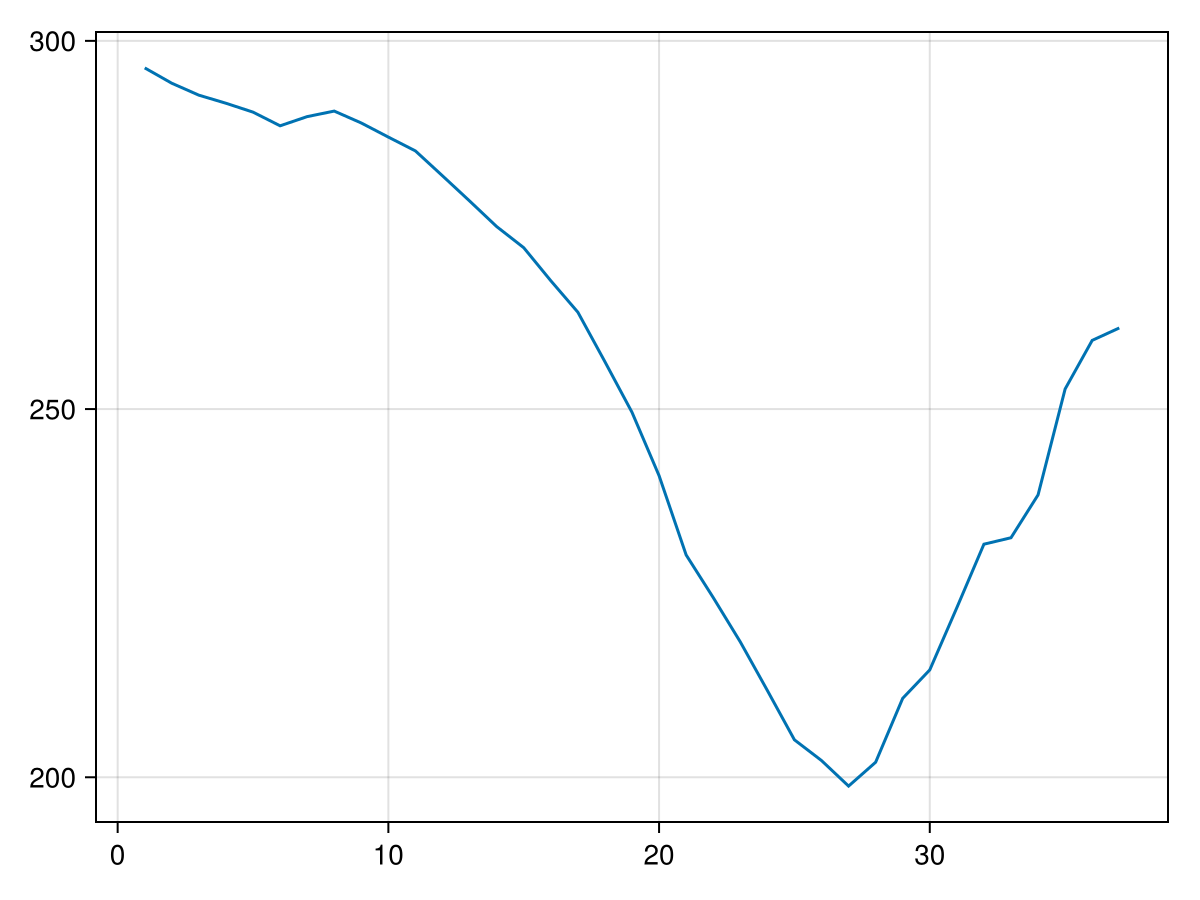

In [54]:
startime = "20070701"
startdates = Dates.DateTime(startime, "yyyymmdd")
startdates
t = nc_fetch("/scratch/julian/ERA5/tv/july_forcing/sim_forcing_loc_17_-149.nc", 
                "ta", 
                startdates + Dates.Second(237600.0), 
                startdates + Dates.Second(259200.0))
using CairoMakie
lines(t)

In [60]:
obs_start, obs_end = startdates + Dates.Second(237600.0), startdates + Dates.Second(259200.0)


(DateTime("2007-07-03T18:00:00"), DateTime("2007-07-04T00:00:00"))

In [49]:
ds = NCDataset("/scratch/julian/ERA5/tv/july_forcing/sim_forcing_loc_17_-149.nc")
ds["hus"][1, 1, :, ds["time"][:]  .> startdates + Dates.Second(237600.0)]

37×53 Matrix{Float64}:
 0.0150915   0.0150824   0.0150572   …  0.013204    0.0133599   0.0133512
 0.0148264   0.0148425   0.0148431      0.0131158   0.0132541   0.0132463
 0.013773    0.0137467   0.0137802      0.0127071   0.0125002   0.0129564
 0.0126191   0.0126924   0.0130277      0.0120267   0.0116042   0.0111788
 0.0116525   0.0117393   0.0118581      0.0111088   0.0112347   0.0106543
 0.0111338   0.0112306   0.0112864   …  0.00979174  0.0102834   0.00892143
 0.00810168  0.00887129  0.00894852     0.0099809   0.0105723   0.00966672
 0.00640602  0.00632448  0.00624103     0.00987136  0.0103655   0.0104876
 0.00457109  0.00462837  0.00487251     0.00712042  0.00760093  0.00799791
 0.00406457  0.00450678  0.00496311     0.00440651  0.004696    0.00496322
 0.00375906  0.00404945  0.00425664  …  0.0027826   0.00280241  0.00286841
 0.00173557  0.00175155  0.00175441     0.00236236  0.00218207  0.00216946
 0.00164113  0.00151811  0.00143061     0.00184786  0.00172181  0.00171555
 ⋮      

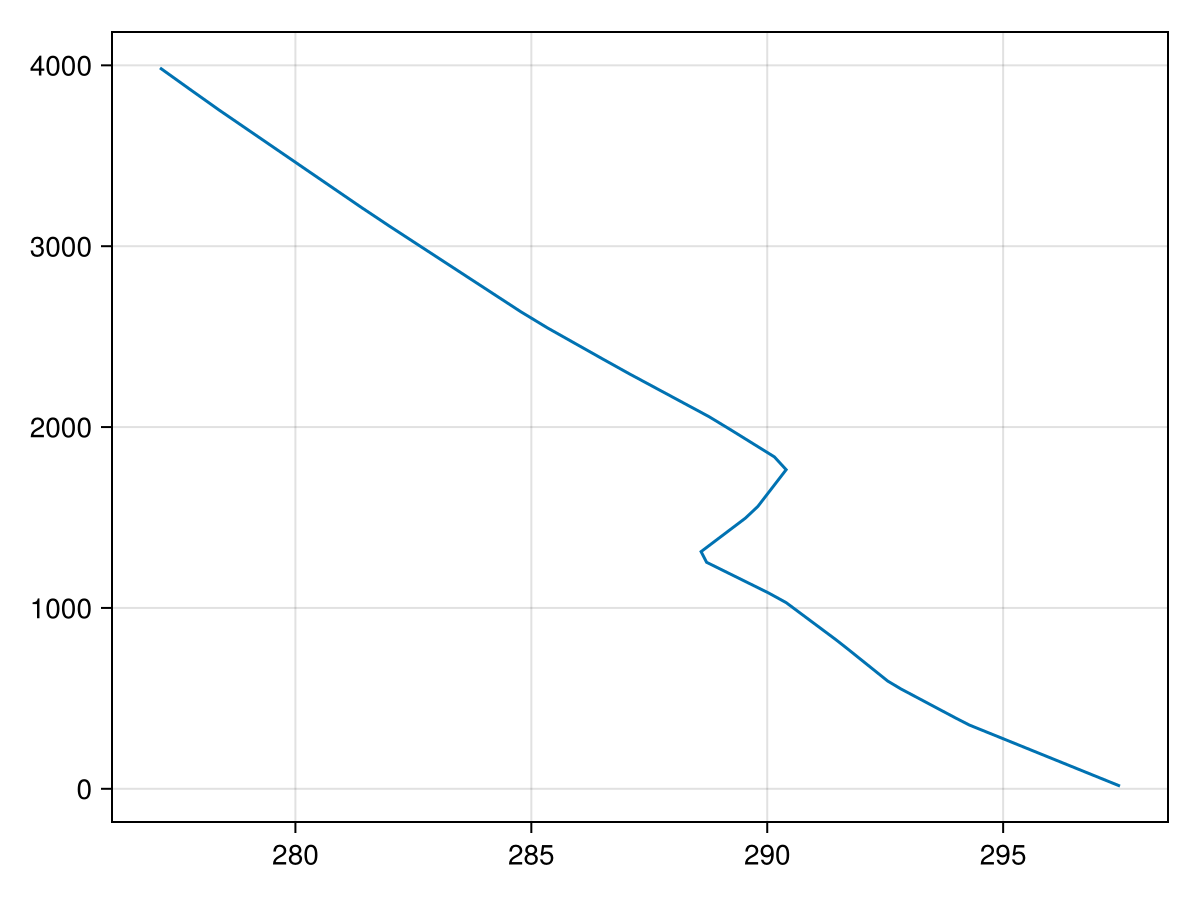

In [69]:
lines(vertical_interpolation(obs_start, obs_end, "ta", "/scratch/julian/ERA5/tv/july_forcing/sim_forcing_loc_17_-149.nc", z_scm), z_scm)

In [73]:
test_obs = get_obs("/scratch/julian/ERA5/tv/july_forcing/sim_forcing_loc_17_-149.nc",
        ["ta", "hus", "clw"],
        obs_start,
        obs_end,
        normalize = false, 
        z_scm = z_scm,
)

186-element Vector{Float64}:
 297.47663194878623
 297.18953639222696
 296.8957249631729
 296.59504369141183
 296.28733514267265
 295.9724384547089
 295.65018944555067
 295.3204199639939
 294.98295853911094
 294.63762936990037
 294.2842537686447
 293.99809385072695
 293.71586795284685
   ⋮
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

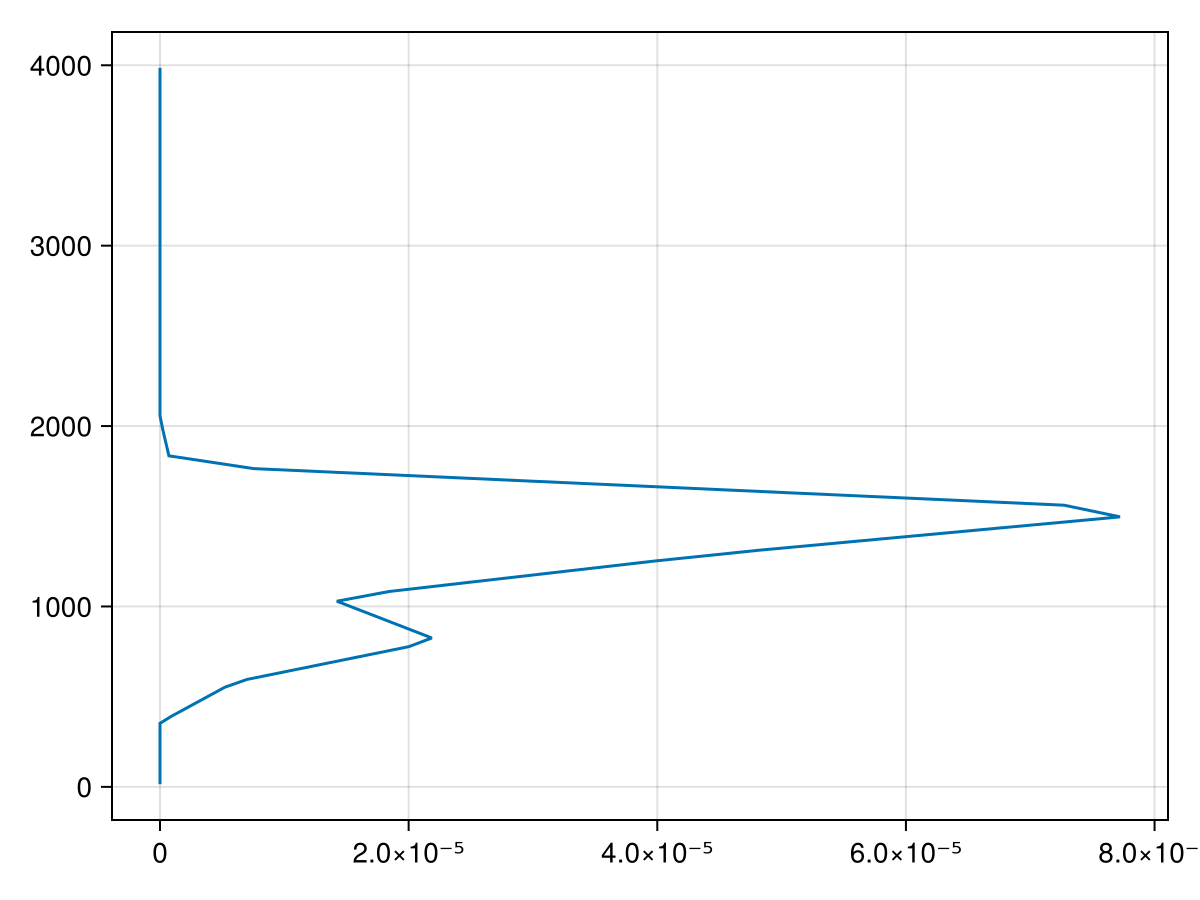

In [78]:
lines(test_obs[125:end], z_scm)